In [46]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pylab as plt
%pip install seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator


from sklearn import set_config

%pip install mlflow dagshub
import mlflow
import mlflow.sklearn
import dagshub

set_config(transform_output="pandas")
plt.style.use('fivethirtyeight')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [47]:
import dagshub
dagshub.init(repo_owner='Arej02', repo_name='swiggy_delivery_time_prediction', mlflow=True)

Initialized MLflow to track repo "Arej02/swiggy_delivery_time_prediction"

Repository Arej02/swiggy_delivery_time_prediction initialized!

In [48]:
swiggy=pd.read_csv("swiggy_cleaned.csv")

In [49]:
swiggy.sample(3)

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,time_taken,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance
31752,MUMRES19DEL02,27.0,4.9,19.131141,72.813074,19.151141,72.833074,2022-03-30,sandstorms,low,...,15,MUM,30,3,wednesday,0,10.0,8.0,morning,3.059363
13797,RANCHIRES20DEL03,20.0,5.0,23.399250,85.390464,23.489250,85.480464,2022-03-27,windy,medium,...,27,RANCHI,27,3,sunday,1,10.0,17.0,evening,13.581198
38010,MYSRES04DEL01,28.0,4.8,12.308500,76.665808,12.318500,76.675808,2022-04-01,fog,low,...,12,MYS,1,4,friday,0,10.0,8.0,morning,1.554551


In [50]:
swiggy['distance'].describe()

count    41872.000000
mean         9.719296
std          5.602890
min          1.465067
25%          4.657655
50%          9.193014
75%         13.680920
max         20.969489
Name: distance, dtype: float64

In [51]:
def bin_distance(df:pd.DataFrame,num_col):
    distance_labels=['short','medium','long','very long']
    distance_bins=[1,6,12,18,24]
    df['distance_bins']=pd.cut(df[num_col],bins=distance_bins,labels=distance_labels,right=False)
    return df

In [52]:
bin_distance(swiggy,'distance')

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_bins
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [53]:
swiggy['order_time_hour'].describe()

count    43862.000000
mean        17.423966
std          4.817856
min          0.000000
25%         15.000000
50%         19.000000
75%         21.000000
max         23.000000
Name: order_time_hour, dtype: float64

In [54]:
def bin_time(df:pd.DataFrame,num_col):
    time_labels=['after_midnight','morning','afternoon','evening','night']
    time_bins=[0,6,12,17,20,24]
    df['order_time_bins']=pd.cut(df[num_col],bins=time_bins,labels=time_labels,right=False)
    return df

In [55]:
bin_time(swiggy,'order_time_hour')

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_bins,order_time_bins
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,19,3,saturday,1,15.0,11.0,morning,3.025149,short,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,25,3,friday,0,5.0,19.0,evening,20.183530,very long,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,19,3,saturday,1,15.0,8.0,morning,1.552758,short,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,24,3,thursday,0,10.0,11.0,morning,1.489846,short,morning
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN,evening
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,11,3,friday,0,15.0,23.0,night,4.657195,short,night
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium,afternoon


#### Dropping missing values:

In [56]:
mlflow.set_tracking_uri("https://dagshub.com/Arej02/swiggy_delivery_time_prediction.mlflow")

In [57]:
mlflow.set_experiment("Exp1:Drop or Keep Missing Values")

<Experiment: artifact_location='mlflow-artifacts:/64dc0d40680544fa8f99e6765466bd0b', creation_time=1757513419784, experiment_id='0', last_update_time=1757513419784, lifecycle_stage='active', name='Exp1:Drop or Keep Missing Values', tags={}>

In [58]:
df1=swiggy.copy().dropna()
df1

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_bins,order_time_bins
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,19,3,saturday,1,15.0,11.0,morning,3.025149,short,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,25,3,friday,0,5.0,19.0,evening,20.183530,very long,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,19,3,saturday,1,15.0,8.0,morning,1.552758,short,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,RANCHIRES16DEL01,35.0,4.2,23.371292,85.327872,23.481292,85.437872,2022-03-08,windy,jam,...,8,3,tuesday,0,10.0,21.0,night,16.600272,long,night
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,24,3,thursday,0,10.0,11.0,morning,1.489846,short,morning
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,11,3,friday,0,15.0,23.0,night,4.657195,short,night
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium,afternoon


In [59]:
columns_to_drop=[
    'rider_id',
    'restaurant_latitude',
    'restaurant_longitude',	
    'delivery_latitude',
    'delivery_longitude',
    'order_date',
    'order_time_of_day',
    "order_time_hour",
    "order_day",
    "city_name",
    "order_day_of_week",
    "order_month"
]

In [60]:
df1.drop(columns=columns_to_drop,inplace=True)

In [61]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38064 entries, 0 to 45501
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  38064 non-null  float64 
 1   ratings              38064 non-null  float64 
 2   weather              38064 non-null  object  
 3   traffic              38064 non-null  object  
 4   vehicle_condition    38064 non-null  int64   
 5   type_of_order        38064 non-null  object  
 6   type_of_vehicle      38064 non-null  object  
 7   multiple_deliveries  38064 non-null  float64 
 8   festival             38064 non-null  object  
 9   city_type            38064 non-null  object  
 10  time_taken           38064 non-null  int64   
 11  is_weekend           38064 non-null  int64   
 12  pickup_time_minutes  38064 non-null  float64 
 13  distance             38064 non-null  float64 
 14  distance_bins        38064 non-null  category
 15  order_time_bins      380

In [62]:
df1.isnull().mean()

age                    0.0
ratings                0.0
weather                0.0
traffic                0.0
vehicle_condition      0.0
type_of_order          0.0
type_of_vehicle        0.0
multiple_deliveries    0.0
festival               0.0
city_type              0.0
time_taken             0.0
is_weekend             0.0
pickup_time_minutes    0.0
distance               0.0
distance_bins          0.0
order_time_bins        0.0
dtype: float64

In [63]:
df1.duplicated().sum()

np.int64(0)

In [64]:
X=df1.drop(columns=['time_taken'])
X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,distance,distance_bins,order_time_bins
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,3.025149,short,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,20.183530,very long,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,1.552758,short,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,7.790401,medium,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,6.210138,medium,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,16.600272,long,night
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,1.489846,short,morning
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,4.657195,short,night
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,6.232393,medium,afternoon


In [65]:
Y=df1['time_taken']
Y

0        24
1        33
2        26
3        21
4        30
         ..
45496    33
45497    32
45499    16
45500    26
45501    36
Name: time_taken, Length: 38064, dtype: int64

In [66]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

In [67]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30451, 15)
The shape of test data is (7613, 15)


In [68]:
numerical_col=[cols for cols in df1.columns if df1[cols].dtype in ['int64','float64'] and cols !='time_taken']
numerical_col

['age',
 'ratings',
 'vehicle_condition',
 'multiple_deliveries',
 'is_weekend',
 'pickup_time_minutes',
 'distance']

In [69]:
categorical_col=[cols for cols in df1.columns if df1[cols].dtype in ['object','category']]
categorical_col

['weather',
 'traffic',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'distance_bins',
 'order_time_bins']

In [70]:
nominal_col=['weather','type_of_order','type_of_vehicle','festival','distance_bins','order_time_bins']
ordinal_col=['traffic','city_type']

In [71]:
len(numerical_col+nominal_col+ordinal_col)

15

In [72]:
df1['traffic'].unique()

array(['high', 'jam', 'low', 'medium'], dtype=object)

In [73]:
df1['city_type'].unique()

array(['urban', 'metropolitian', 'semi-urban'], dtype=object)

In [74]:
traffic_groups=['low','medium','high','jam']
city_groups=['semi-urban','urban','metropolitian']

In [75]:
preprocessor=ColumnTransformer(
    [
        ("scaler",StandardScaler(),numerical_col),
        ("ohe",OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"),nominal_col),
        ("ordinal",OrdinalEncoder(categories=[traffic_groups,city_groups]),ordinal_col)
    ],remainder='passthrough'
)
preprocessor.set_output(transform="pandas")

,transformers,"[('scaler', ...), ('ohe', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [76]:
base_model=RandomForestRegressor()

In [77]:
pipeline=Pipeline([
    ("preprocessor",preprocessor),
    ("base_model",base_model)
])

In [78]:
pipeline.fit(X_train,Y_train)

,steps,"[('preprocessor', ...), ('base_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('ohe', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [79]:
y_pred_test=pipeline.predict(X_test)
y_pred_train=pipeline.predict(X_train)

In [80]:
print(f"The train mean absolute error is:{round(mean_absolute_error(Y_train,y_pred_train),2)} min")
print(f"The test mean absolute error is:{round(mean_absolute_error(Y_test,y_pred_test),2)} min")

The train mean absolute error is:1.15 min
The test mean absolute error is:3.14 min


In [81]:
print(f"The train r2 score is:{round(r2_score(Y_train,y_pred_train),2)}")
print(f"The test r2 score is:{round(r2_score(Y_test,y_pred_test),2)}")

The train r2 score is:0.98
The test r2 score is:0.82


In [82]:
scores = cross_val_score(pipeline,X_train,Y_train,cv=5,scoring="r2",n_jobs=-1)

In [83]:
#Log Experiments:

with mlflow.start_run(run_name="Drop Missing Values"):
    mlflow.log_param("experiment_type","Drop Missing Values")
    mlflow.log_params(base_model.get_params())

    mlflow.log_metric("training error",mean_absolute_error(Y_train,y_pred_train))
    mlflow.log_metric("test error",mean_absolute_error(Y_test,y_pred_test))
    mlflow.log_metric("train R2 score",r2_score(Y_train,y_pred_train))
    mlflow.log_metric("test R2 score",r2_score(Y_test,y_pred_test))
    mlflow.log_metric("Cross_val",scores.mean())

🏃 View run Drop Missing Values at: https://dagshub.com/Arej02/swiggy_delivery_time_prediction.mlflow/#/experiments/0/runs/86557dc574c946ada8b5165400737bb8
🧪 View experiment at: https://dagshub.com/Arej02/swiggy_delivery_time_prediction.mlflow/#/experiments/0


#### Imputing the missing values:

In [84]:
df2=swiggy.copy()
df2

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_bins,order_time_bins
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,19,3,saturday,1,15.0,11.0,morning,3.025149,short,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,25,3,friday,0,5.0,19.0,evening,20.183530,very long,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,19,3,saturday,1,15.0,8.0,morning,1.552758,short,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,24,3,thursday,0,10.0,11.0,morning,1.489846,short,morning
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN,evening
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,11,3,friday,0,15.0,23.0,night,4.657195,short,night
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium,afternoon


In [85]:
df2.drop(columns=columns_to_drop,inplace=True)

In [86]:
X=df2.drop(columns=['time_taken'])
X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,distance,distance_bins,order_time_bins
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,3.025149,short,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,20.183530,very long,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,1.552758,short,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,7.790401,medium,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,6.210138,medium,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,1.489846,short,morning
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,0,15.0,NaN,NaN,evening
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,4.657195,short,night
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,6.232393,medium,afternoon


In [87]:
Y=df2['time_taken']
Y

0        24
1        33
2        26
3        21
4        30
         ..
45497    32
45498    36
45499    16
45500    26
45501    36
Name: time_taken, Length: 45502, dtype: int64

In [88]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

In [89]:
print("The shape of training dataset is:",X_train.shape)
print("The shape of testing dataset is:",X_test.shape)

The shape of training dataset is: (36401, 15)
The shape of testing dataset is: (9101, 15)


In [90]:
pt=PowerTransformer()

In [91]:
Y_train_pt=pt.fit_transform(Y_train.values.reshape(-1,1))
Y_test_pt=pt.transform(Y_test.values.reshape(-1,1))

In [92]:
X_train.isnull().mean()*100

age                    4.027362
ratings                4.150985
weather                1.170298
traffic                1.140079
vehicle_condition      0.000000
type_of_order          0.000000
type_of_vehicle        0.000000
multiple_deliveries    2.236202
festival               0.480756
city_type              2.596083
is_weekend             0.000000
pickup_time_minutes    3.579572
distance               7.878904
distance_bins          7.878904
order_time_bins        3.579572
dtype: float64

In [93]:
X_train['age'].describe()

count    34935.000000
mean        29.583598
std          5.763287
min         20.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         39.000000
Name: age, dtype: float64

In [94]:
test_stats,p_value=stats.jarque_bera(X_train['age'].dropna())
p_value

np.float64(0.0)

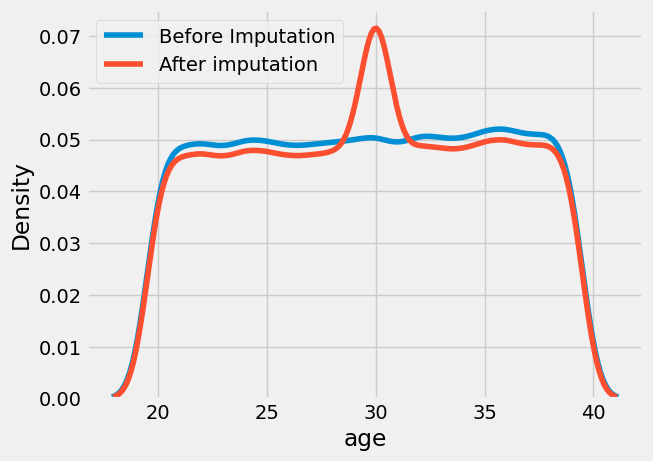

In [95]:
sns.kdeplot(X_train['age'],label="Before Imputation")
sns.kdeplot(X_train['age'].fillna(X_train['age'].median()),label="After imputation")

plt.legend()
plt.show()

Age is not normally distributed and has <5% missing data. So, here we try to impute it using median, however, we can see that there is a peak around 30 years which is the medain value that was used to impute the missing values. Thus, the distribution hasnot been preserved. 

In [96]:
X_train['ratings'].describe()

count    34890.000000
mean         4.633411
std          0.316294
min          2.500000
25%          4.500000
50%          4.700000
75%          4.900000
max          5.000000
Name: ratings, dtype: float64

In [97]:
test_stats,p_value=stats.jarque_bera(X_train['ratings'].dropna())
p_value

np.float64(0.0)

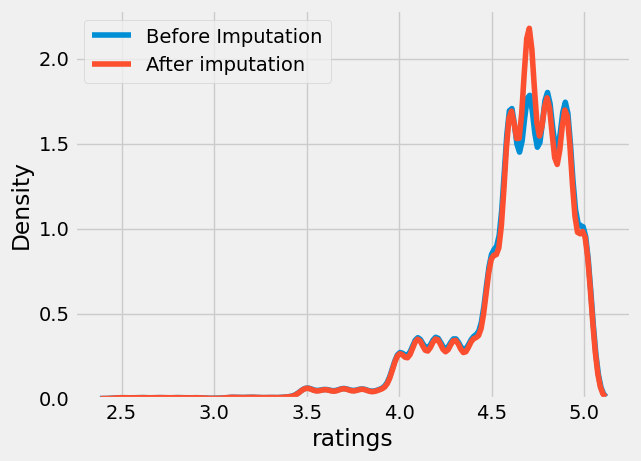

In [98]:
sns.kdeplot(X_train['ratings'],label="Before Imputation")
sns.kdeplot(X_train['ratings'].fillna(X_train['ratings'].median()),label="After imputation")

plt.legend()
plt.show()

Rating is not normally distributed and has <5% missing data. So, here we try to impute it using median. Though there is a slight peak in the median value, much of the distribution is preserved. 

In [99]:
X_train['weather'].value_counts()

weather
fog           6141
stormy        6125
sandstorms    6005
cloudy        5941
windy         5912
sunny         5851
Name: count, dtype: int64

No dominant category here. So, we will not fill it with the mode. 

In [100]:
X_train['traffic'].value_counts()

traffic
low       12365
jam       11329
medium     8768
high       3524
Name: count, dtype: int64

No dominant category here. So, we will not fill it with the mode. 

In [101]:
X_train['multiple_deliveries'].value_counts()

multiple_deliveries
1.0    22557
0.0    11141
2.0     1611
3.0      278
Name: count, dtype: int64

1 is the dominant category, so we can fill it with the mode. 

In [102]:
X_train['festival'].value_counts()

festival
no     35492
yes      734
Name: count, dtype: int64

"No" is the dominant category, so we can fill it with the mode. 

In [103]:
X_train['city_type'].value_counts()

city_type
metropolitian    27267
urban             8055
semi-urban         134
Name: count, dtype: int64

"metropolitian" is the dominant category, so we can fill it with the mode. 

In [104]:
X_train['pickup_time_minutes'].describe()

count    35098.000000
mean         9.995441
std          4.094154
min          5.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         15.000000
Name: pickup_time_minutes, dtype: float64

In [105]:
test_stats,p_value=stats.jarque_bera(X_train['pickup_time_minutes'].dropna())
p_value

np.float64(0.0)

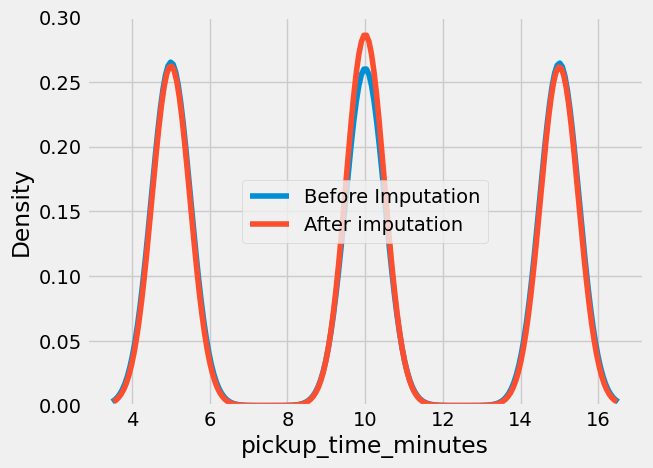

In [106]:
sns.kdeplot(X_train['pickup_time_minutes'],label="Before Imputation")
sns.kdeplot(X_train['pickup_time_minutes'].fillna(X_train['pickup_time_minutes'].median()),label="After imputation")

plt.legend()
plt.show()

Here, we can see that the multimodel pattern largely remains preserved after the imputation.

In [107]:
X_train['distance'].describe()

count    33533.000000
mean         9.741460
std          5.605947
min          1.465067
25%          4.657673
50%          9.219124
75%         13.681416
max         20.969489
Name: distance, dtype: float64

In [108]:
test_stats,p_value=stats.jarque_bera(X_train['distance'].dropna())
p_value

np.float64(0.0)

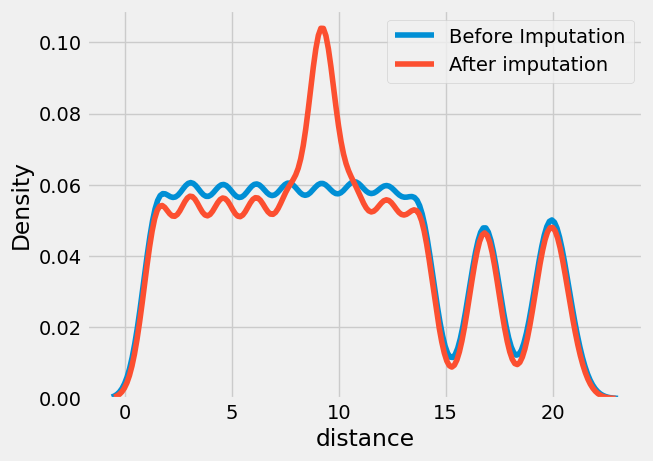

In [109]:
sns.kdeplot(X_train['distance'],label="Before Imputation")
sns.kdeplot(X_train['distance'].fillna(X_train['distance'].median()),label="After imputation")

plt.legend()
plt.show()

There is a peak in the median value after the imputation. so the distribution is not preserved. 

In [110]:
X_train['distance_bins'].value_counts()

distance_bins
medium       12104
short         9398
long          8577
very long     3454
Name: count, dtype: int64

In [111]:
X_train['order_time_bins'].value_counts()

order_time_bins
night             14683
evening           10678
morning            6169
afternoon          3217
after_midnight      351
Name: count, dtype: int64

There is no obvious dominant category in both of the features. 

In [112]:
imputing_mode=['multiple_deliveries','festival','city_type']
imputing_median=['ratings','pickup_time_minutes']
imputing_missing_indicator=[col for col in nominal_col if df2[col].dtypes in ['object','category'] and col not in imputing_mode]
imputing_missing_indicator

['weather',
 'type_of_order',
 'type_of_vehicle',
 'distance_bins',
 'order_time_bins']

In [113]:
simple_imputer=ColumnTransformer(
    [
        ("mode",SimpleImputer(strategy="most_frequent"),imputing_mode),
        ("missing_indicator",SimpleImputer(strategy="constant",fill_value="missing"),imputing_missing_indicator),
        ("median",SimpleImputer(strategy="median"),imputing_median)
    ],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False
)
simple_imputer

,transformers,"[('mode', ...), ('missing_indicator', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [114]:
simple_imputer.fit_transform(X_train)

c:\Users\khadk\OneDrive\anaconda3\envs\mlenv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,distance_bins,order_time_bins,ratings,pickup_time_minutes,age,traffic,vehicle_condition,is_weekend,distance
1901,1.0,no,metropolitian,stormy,meal,electric_scooter,missing,evening,4.6,5.0,21.0,medium,2,0,NaN
32233,0.0,no,urban,sandstorms,buffet,motorcycle,medium,evening,4.8,5.0,27.0,medium,1,1,10.867138
41301,2.0,no,metropolitian,stormy,buffet,motorcycle,long,evening,4.4,5.0,31.0,medium,0,0,12.162012
8362,1.0,no,urban,cloudy,buffet,scooter,long,evening,4.0,5.0,35.0,medium,2,0,13.631344
40881,1.0,no,urban,windy,meal,electric_scooter,short,morning,4.7,10.0,20.0,low,2,1,3.073772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40059,1.0,no,metropolitian,stormy,buffet,electric_scooter,very long,night,4.7,5.0,26.0,jam,2,0,20.831034
28017,1.0,no,urban,stormy,drinks,motorcycle,short,morning,4.8,10.0,27.0,low,1,0,1.536850
29199,1.0,no,metropolitian,windy,buffet,motorcycle,very long,evening,4.7,15.0,32.0,medium,0,0,20.852271
40061,0.0,no,metropolitian,sandstorms,meal,motorcycle,medium,night,4.4,10.0,37.0,low,0,0,7.790159


In [115]:
simple_imputer.fit_transform(X_train).isna().mean()*100

c:\Users\khadk\OneDrive\anaconda3\envs\mlenv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


multiple_deliveries    0.000000
festival               0.000000
city_type              0.000000
weather                0.000000
type_of_order          0.000000
type_of_vehicle        0.000000
distance_bins          0.000000
order_time_bins        0.000000
ratings                0.000000
pickup_time_minutes    0.000000
age                    4.027362
traffic                1.140079
vehicle_condition      0.000000
is_weekend             0.000000
distance               7.878904
dtype: float64

In [116]:
numerical_col

['age',
 'ratings',
 'vehicle_condition',
 'multiple_deliveries',
 'is_weekend',
 'pickup_time_minutes',
 'distance']

In [117]:
preprocessor=ColumnTransformer(
    [
        ("scaler",StandardScaler(),numerical_col),
        ("ohe",OneHotEncoder(drop="first",sparse_output=False,handle_unknown="ignore"),nominal_col),
        ("ordinal",OrdinalEncoder(categories=[traffic_groups,city_groups],encoded_missing_value=-999,handle_unknown="use_encoded_value",unknown_value=-1),ordinal_col)
    ],remainder='passthrough'
)

In [118]:
preprocessor.fit_transform(X_train)

,scaler__age,scaler__ratings,scaler__vehicle_condition,scaler__multiple_deliveries,scaler__is_weekend,scaler__pickup_time_minutes,scaler__distance,ohe__weather_fog,ohe__weather_sandstorms,ohe__weather_stormy,...,ohe__distance_bins_short,ohe__distance_bins_very long,ohe__distance_bins_nan,ohe__order_time_bins_afternoon,ohe__order_time_bins_evening,ohe__order_time_bins_morning,ohe__order_time_bins_night,ohe__order_time_bins_nan,ordinal__traffic,ordinal__city_type
1901,-1.489379,-0.105633,1.172137,0.441664,-0.614852,-1.220157,NaN,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
32233,-0.448292,0.526699,-0.024961,-1.309785,1.626408,-1.220157,0.200804,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
41301,0.245766,-0.737965,-1.222059,2.193114,-0.614852,-1.220157,0.431789,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
8362,0.939825,-2.002629,1.172137,0.441664,-0.614852,-1.220157,0.693896,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
40881,-1.662894,0.210533,1.172137,0.441664,1.626408,0.001113,-1.189413,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40059,-0.621806,0.210533,1.172137,0.441664,-0.614852,-1.220157,1.978210,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
28017,-0.448292,0.526699,-0.024961,0.441664,-0.614852,0.001113,-1.463576,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
29199,0.419281,0.210533,-1.222059,0.441664,-0.614852,1.222384,1.981998,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
40061,1.286854,-0.737965,-1.222059,-1.309785,-0.614852,0.001113,-0.348082,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0


In [119]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser : ser.ge(1)]

scaler__age                    1466
scaler__ratings                1511
scaler__multiple_deliveries     814
scaler__pickup_time_minutes    1303
scaler__distance               2868
dtype: int64

In [120]:
knn_imputer=KNNImputer(n_neighbors=5)

In [121]:
preprocessing_pipeline=Pipeline(steps=[
    ("simple_imputer",simple_imputer),
    ("preprocessor",preprocessor),
    ("knn_imputer",knn_imputer)
])

In [122]:
model_pipeline=Pipeline(steps=[
    ("preprocessing_pipeline",preprocessing_pipeline),
    ("base_model",base_model)
])
model_pipeline

,steps,"[('preprocessing_pipeline', ...), ('base_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode', ...), ('missing_indicator', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [123]:
model_pipeline.fit(X_train,Y_train_pt.values.ravel())

c:\Users\khadk\OneDrive\anaconda3\envs\mlenv\lib\site-packages\sklearn\compose\_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessing_pipeline', ...), ('base_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('simple_imputer', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('mode', ...), ('missing_indicator', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3


In [124]:
y_pred_train=model_pipeline.predict(X_train)
y_pred_test=model_pipeline.predict(X_test)

In [125]:
y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [126]:
print(f"The train error is {mean_absolute_error(Y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(Y_test,y_pred_test_org):.2f} minutes")

The train error is 1.22 minutes
The test error is 3.29 minutes


In [127]:
print(f"The train r2 score is {r2_score(Y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(Y_test,y_pred_test_org):.2f}")  

The train r2 score is 0.97
The test r2 score is 0.80


In [128]:
scores = cross_val_score(model_pipeline,X_train,Y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)
scores

array([0.77930721, 0.7813436 , 0.78618332, 0.78522557, 0.77305369])

In [129]:
scores.mean()

np.float64(0.7810226767494524)

In [ ]:
with mlflow.start_run(run_name="Impute Missing Values"):
    mlflow.log_param("experiment_type","Impute Missing Values")
    mlflow.log_params(base_model.get_params())

    mlflow.log_metric("training error",mean_absolute_error(Y_train,y_pred_train_org))
    mlflow.log_metric("test error",mean_absolute_error(Y_test,y_pred_test_org))
    mlflow.log_metric("train R2 score",r2_score(Y_train,y_pred_train_org))
    mlflow.log_metric("test R2 score",r2_score(Y_test,y_pred_test_org))
    mlflow.log_metric("Cross_val",scores.mean())

🏃 View run Impute Missing Values at: https://dagshub.com/Arej02/swiggy_delivery_time_prediction.mlflow/#/experiments/0/runs/2a2ae5e4dc894ec389fbfa81c02a905b
🧪 View experiment at: https://dagshub.com/Arej02/swiggy_delivery_time_prediction.mlflow/#/experiments/0
